In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


from pathlib import Path


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)


# inspector = inspect(engine)
# inspector.get_table_names()

# columns = inspector.get_columns('hawaii')
# for column in columns:
#     print(column['name'], column["type"])


# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


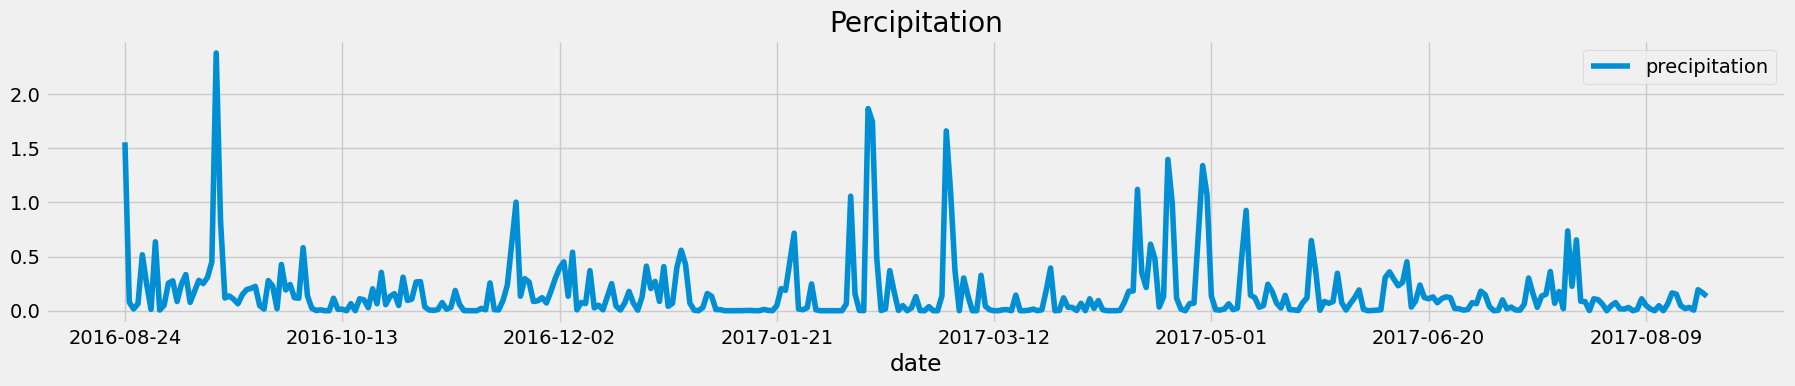

,date,precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


<Figure size 640x480 with 0 Axes>

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

precip_year_data = session.query(Measurement.date).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()



results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
      filter(Measurement.date < "2017-08-24").\
      filter(Measurement.date > "2016-08-23").\
        order_by(Measurement.date).\
        group_by(Measurement.date).\
        all()
df = pd.DataFrame(results, columns = ["date", "precipitation"])
df.head()



# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x= 'date', y='precipitation', figsize=(20,3.5))

# Set a title for the chart
plt.title("Percipitation")

plt.show()
plt.tight_layout()


# Sort the dataframe by date
df.sort_values('date')
df.head()




In [11]:
inspector = inspect(engine)
inspector.get_table_names()

measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data


precip_full_data = session.query(Measurement.date, Measurement.prcp)
precip_df = pd.DataFrame(precip_full_data, columns=['date','prcp'])
precip_df.describe()



,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [13]:
#just looking at the columns
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
print(columns)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [15]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(Station.station).distinct().count()
print(total_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

results = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = results[0][0]
#most_active
min_max_avg = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
# min_max_avg
session.query(*min_max_avg).all()

[(53.0, 87.0, 73.09795396419437)]

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_year = session.query(Measurement.tobs).\
    order_by(Measurement.tobs).\
    filter(Measurement.date < "2017-08-24").\
    filter(Measurement.date > "2016-08-23").\
    filter(Measurement.station==most_active).all()

year_df = pd.DataFrame(results, columns = ["tobs"])
year_df.head()

figure1 = year_df.plot(kind="hist", color=["red", "blue"], figsize=(8,6),
                                   title="12 Months of Temperatures",
                                   xlabel="Counts",
                                   ylabel="Temp")


ValueError: 1 columns passed, passed data had 2 columns

# Close Session

In [20]:
# Close Session
session.close()